In [1]:
#import libraries
import warnings 
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import scipy.io as spio
import scipy.signal
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
import math 
import re 
import pandas as pd
import os
import glob
from os.path import expanduser
import datetime
import statistics as stats
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


In [2]:
def color_negative_red(val):
    color = 'red' if val > 110 else 'black'
    return 'color: %s' % color


In [3]:
class Keypoint:
    tag = ""
    parent = ['']
    child = ['']
    point = None

    def __init__(self,tag=None,parent=None,child=None,point=None):
        if tag is not None:            
            self.tag = tag
        if parent is not None:
            self.parent = parent
        if child is not None:
            self.child = child
        if point is not None:
            self.point = point


In [4]:
class Skeleton:
    keypoints = [Keypoint() for i in range(17)]
    tag2id = {
        "shoulderCenter" : 0,
        "head" : 1,
        "shoulderLeft" : 2,
        "elbowLeft" : 3,
        "handLeft" : 4,
        "shoulderRight" : 5,
        "elbowRight" : 6,
        "handRight" : 7,
        "hipCenter" : 8,
        "hipLeft" : 9,
        "kneeLeft" : 10,
        "ankleLeft" : 11,
        "footLeft" : 12,
        "hipRight" : 13,
        "kneeRight" : 14,
        "ankleRight" : 15,
        "footRight" : 16,
    }
    keypoints[tag2id["shoulderCenter"]] = Keypoint("shoulderCenter",[''],['head','shoulderLeft','shoulderRight','hipCenter'])
    keypoints[tag2id["head"]] = Keypoint("head",['shoulderCenter'],[''])
    keypoints[tag2id["shoulderLeft"]] = Keypoint("shoulderLeft",['shoulderCenter'],['elbowLeft'])
    keypoints[tag2id["elbowLeft"]] = Keypoint("elbowLeft",['shoulderLeft'],['handLeft'])
    keypoints[tag2id["handLeft"]] = Keypoint("handLeft",['elbowLeft'],[''])
    keypoints[tag2id["shoulderRight"]] = Keypoint("shoulderRight",['shoulderCenter'],['elbowRight'])
    keypoints[tag2id["elbowRight"]] = Keypoint("elbowRight",['shoulderRight'],['handRight'])
    keypoints[tag2id["handRight"]] = Keypoint("handRight",['elbowRight'],[''])
    keypoints[tag2id["hipCenter"]] = Keypoint("hipCenter",['shoulderCenter'],['hipLeft','hipRight'])
    keypoints[tag2id["hipLeft"]] = Keypoint("hipLeft",['shoulderCenter'],['kneeLeft'])
    keypoints[tag2id["kneeLeft"]] = Keypoint("kneeLeft",['hipLeft'],['ankleLeft'])
    keypoints[tag2id["ankleLeft"]] = Keypoint("ankleLeft",['kneeLeft'],['footLeft'])
    keypoints[tag2id["footLeft"]] = Keypoint("footLeft",['ankleLeft'],[''])
    keypoints[tag2id["hipRight"]] = Keypoint("hipRight",['shoulderCenter'],['kneeRight'])
    keypoints[tag2id["kneeRight"]] = Keypoint("kneeRight",['hipRight'],['ankleRight'])
    keypoints[tag2id["ankleRight"]] = Keypoint("ankleRight",['kneeRight'],['footRight'])
    keypoints[tag2id["footRight"]] = Keypoint("footRight",['ankleRight'],[''])

    def __init__(self,keyp_map=None):
        if keyp_map is not None:
            for tag in keyp_map.keys():
                self.keypoints[self.tag2id[tag]].point = keyp_map[tag] 

    def getKeypoint(self,keyp_tag):
        return self.keypoints[self.tag2id[keyp_tag]].point

    def getChild(self,keyp_tag):
        return self.keypoints[self.tag2id[keyp_tag]].child

    def getParent(self,keyp_tag):
        return self.keypoints[self.tag2id[keyp_tag]].parent

    def getTransformation(self):
        sagittal = None
        coronal = None
        transverse = None
        T = np.eye(4,4)
        if self.getKeypoint("shoulderLeft") is not None:
            if self.getKeypoint("shoulderRight") is not None:
                sagittal = self.getKeypoint("shoulderLeft")[0]-self.getKeypoint("shoulderRight")[0]
                sagittal = sagittal/np.linalg.norm(sagittal)
        if self.getKeypoint("shoulderCenter") is not None:
            if self.getKeypoint("hipLeft") is not None:
                if self.getKeypoint("hipRight") is not None:
                    transverse = self.getKeypoint("shoulderCenter")[0]-0.5*(self.getKeypoint("hipLeft")[0]+self.getKeypoint("hipRight")[0])
                    transverse = transverse/np.linalg.norm(transverse)
        if self.getKeypoint("shoulderCenter") is not None:
            pSC = self.getKeypoint("shoulderCenter")[0]

        if sagittal is not None:
            if coronal is not None:
                coronal = np.cross(sagittal,transverse)
                T[0,0]=coronal[0]
                T[1,0]=coronal[1]
                T[2,0]=coronal[2]
                T[0,1]=sagittal[0]
                T[1,1]=sagittal[1]
                T[2,1]=sagittal[2]
                T[0,2]=transverse[0]
                T[1,2]=transverse[1]
                T[2,2]=transverse[2]
                T[0,3]=pSC[0]
                T[1,3]=pSC[1]
                T[2,3]=pSC[2]
                T[3,3]=1
        return T

    def show(self):
        for i in range(len(self.keypoints)):
            k = self.keypoints[i]
            print("keypoint[", k.tag, "]", "=", k.point)


In [5]:
class Exercise:
    name = ""
    typee = ""
    metrics = []

class Tug(Exercise):
    name = "tug"
    typee = "test"
    metrics = ["ROM_0","ROM_1","ROM_2","ROM_3","ROM_4","ROM_5","step_0"]
    result = []
    month_res = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: [],
        6: [],
        7: [],
        8: [],
        9: [],
        10: [],
        11: []
    }

    def __init__(self,month,result):
        self.result = result
        self.month_res[month] = result

    def getResult(self,month):
        return self.month_res[month]



In [6]:
# class Metric:
#     name = ''

#     def __init__(self,name):
#         self.name = name


# class Step(Metric):
#     name = "step"
#     en_projection = False
#     medfilt = 1
#     step_thresh = 0.0
#     tstart = 0.0
#     tend = 0.0
#     step_length = []
#     step_width = []
#     step_distance = []
#     filtered_step_distance = []
#     strikes = []
#     nsteps = 0
#     cadence = 0.0
#     speed = 0.0
#     ex_time = 0.0
    
#     def __init__(self,medfilt_window,en_projection,tstart,tend,step_thresh):

#         # scipy median filter requires odd kernel size
#         self.medfilt = int(medfilt_window)
#         if not (self.medfilt & 1):
#             self.medfilt = self.medfilt + 1

#         self.tstart = tstart
#         self.tend = tend
#         self.step_thresh = step_thresh
#         self.en_projection = en_projection

#     def compute(self,skeleton):
#         alj = skeleton.getKeypoint("ankleLeft")
#         arj = skeleton.getKeypoint("ankleRight")
#         ankles_diff = alj[:, :2] - arj[:, :2]

#         if self.en_projection:
#             if skeleton.getKeypoint("shoulderLeft") is not None and skeleton.getKeypoint("shoulderRight") is not None:
#                 sagittal = skeleton.getKeypoint("shoulderLeft")[0] - skeleton.getKeypoint("shoulderRight")[0]
#                 sagittal = sagittal / np.linalg.norm(sagittal)
#             for i in range(len(alj)):
#                 v = alj[i,:] - arj[i,:]
#                 dist = np.dot(v,np.transpose(sagittal))
#                 v = v - dist * sagittal
#                 self.step_distance.append(np.linalg.norm(v))
#                 self.filtered_step_distance = scipy.signal.medfilt(self.step_distance,kernel_size=self.medfilt)
#         else:
#             # ankles_diff_filtered = scipy.ndimage.median_filter(ankles_diff, size = (self.medfilt, self.medfilt))
#             ankles_diff_filtered = scipy.signal.savgol_filter(ankles_diff, 20, 2, axis=0)
#             self.filtered_step_distance = np.linalg.norm(ankles_diff_filtered, axis=1)
#             self.step_distance = np.linalg.norm(ankles_diff, axis=1)

#             outliers_indices = np.where(np.abs(scipy.stats.zscore(self.filtered_step_distance)) > 3)[0]
#             self.filtered_step_distance[outliers_indices] = 0.0

#         #self.strikes = scipy.signal.find_peaks_cwt(self.filtered_step_distance, np.arange(1, 42), min_snr=1)
#         self.strikes,_ = scipy.signal.find_peaks(self.filtered_step_distance, height = self.step_thresh, distance = 10)
#         slen = self.filtered_step_distance[self.strikes]
#         self.step_length = stats.mean(slen)
#         self.step_width = np.fabs(ankles_diff)
#         self.nsteps = len(self.strikes)
#         self.cadence = self.nsteps / (self.tend - self.tstart)
#         self.speed = self.step_length * self.cadence
#         self.ex_time = self.tend - self.tstart


In [212]:
class Metric:
    name = ''

    def __init__(self,name):
        self.name = name


class Step(Metric):
    name = "step"
    en_projection = False
    medfilt = 1
    step_thresh = 0.0
    tstanding = []
    tforward = []
    tturning1 = []
    tbackward = []
    tturning2 = []
    tsitting = []
    tend = []
    step_length = []
    step_width = []
    step_distance = []
    filtered_step_distance = []
    strikes = []
    nsteps = 0
    cadence = 0.0
    ex_time = 0.0
    speed = 0.0 
    speed_z = 0.0 
    
    def __init__(self,medfilt_window,en_projection, tstanding, tforward, tturning1, tbackward, tturning2, tsitting, tend, step_thresh):

        # scipy median filter requires odd kernel size
        self.medfilt = int(medfilt_window)
        if not (self.medfilt & 1):
            self.medfilt = self.medfilt + 1

        self.step_thresh = step_thresh
        self.en_projection = en_projection
        self.tstanding = tstanding
        self.tforward = tforward
        self.tturning1 = tturning1
        self.tbackward = tbackward
        self.tturning2 = tturning2
        self.tsitting = tsitting
        self.tend = tend

    def compute_kinematics(skeleton, tag):
        sc = skeleton.getKeypoint(tag)

        win=10
        poly_ord=2
        dev_ord=1

        acc_x = scipy.signal.savgol_filter(sc[:,0], win, poly_ord, 2, delta = time[0][1]-time[0][0], axis=0)
        acc_y = scipy.signal.savgol_filter(sc[:,1], win, poly_ord, 2, delta = time[0][1]-time[0][0], axis=0)
        acc_z = scipy.signal.savgol_filter(sc[:,2], win, poly_ord, 2, delta = time[0][1]-time[0][0], axis=0)
        vel_x = scipy.signal.savgol_filter(sc[:,0], win, poly_ord, dev_ord, delta = time[0][1]-time[0][0], axis=0)
        vel_y = scipy.signal.savgol_filter(sc[:,1], win, poly_ord, dev_ord, delta = time[0][1]-time[0][0], axis=0)
        vel_z = scipy.signal.savgol_filter(sc[:,2], win, poly_ord, dev_ord, delta = time[0][1]-time[0][0], axis=0)        

        return vel_x, vel_y, vel_z, acc_x, acc_y, acc_z

    def compute_timing(self, skeleton):
        dur= 49 #49
        nsigma=3

        vel_shoulCenter_x, vel_shoulCenter_y, vel_shoulCenter_z, acc_shoulCenter_x, acc_shoulCenter_y, acc_shoulCenter_z= compute_kinematics(skeleton, "shoulderCenter")
        vel_hipCenter_x, vel_hipCenter_y, vel_hipCenter_z, acc_hipCenter_x, acc_hipCenter_y, acc_hipCenter_z = compute_kinematics(skeleton, "hipCenter")
        vel_ankleLeft_x, vel_ankleLeft_y, vel_ankleLeft_z, acc_ankleLeft_x, acc_ankleLeft_y, acc_ankleLeft_z = compute_kinematics(skeleton, "ankleLeft")
        vel_ankleRight_x, vel_ankleRight_y, vel_ankleRight_z, acc_ankleRight_x, acc_ankleRight_y, acc_ankleRight_z = compute_kinematics(skeleton, "ankleRight")
        vel_shoulRight_x, vel_shoulRight_y, vel_shoulRight_z, acc_shoulRight_x, acc_shoulRight_y, acc_shoulRight_z = compute_kinematics(skeleton, "shoulderRight")
        vel_shoulLeft_x, vel_shoulLeft_y, vel_shoulLeft_z, acc_shoulLeft_x, acc_shoulLeft_y, acc_shoulLeft_z = compute_kinematics(skeleton, "shoulderLeft")

        ###
        init_mean= np.mean(acc_hipCenter_z[0:dur])
        init_std= np.std(acc_hipCenter_z[0:dur])
        cond1 = np.where(np.abs((acc_hipCenter_z-init_mean)/init_std) > nsigma)[0]
        cond2=np.where(np.diff(np.sign(acc_hipCenter_y-acc_shoulCenter_y)))[0]

        in_stand_idx= np.intersect1d(cond1,cond2)[0]

        ###
        init_mean= np.mean(acc_ankleRight_y[0:dur])
        init_std= np.std(acc_ankleRight_y[0:dur])
        in_wf_Right_y_idx = np.where(np.abs((acc_ankleRight_y-init_mean)/init_std) > nsigma)[0]
        in_wf_Right_y_idx = np.where(vel_ankleRight_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
        init_mean= np.mean(acc_ankleLeft_y[0:dur])
        init_std= np.std(acc_ankleLeft_y[0:dur])
        in_wf_Left_y_idx = np.where(np.abs((acc_ankleLeft_y-init_mean)/init_std) > nsigma)[0]
        in_wf_Left_y_idx = np.where(vel_ankleLeft_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
        #in_wf_idx= np.minimum(in_wf_Right_y_idx, in_wf_Left_y_idx)[0]
        if in_wf_Right_y_idx[0]<in_wf_Left_y_idx[0]:
            cond1 = in_wf_Right_y_idx
        else:
            cond1 = in_wf_Left_y_idx
        cond2 = np.array(np.where(vel_hipCenter_y[in_stand_idx:]<0.))[0]+in_stand_idx-2#
        in_wf_idx=np.intersect1d(cond1,cond2)[0]

        diff_vel_x=vel_shoulRight_x-vel_shoulLeft_x
        diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
        cond1= np.array(np.where(diff_acc_x>0))[0]

        rfoot_cross3m = np.array(np.where(s.keypoints[15].point[:,1]<-3.))[0]#
        lfoot_cross3m = np.array(np.where(s.keypoints[11].point[:,1]<-3.))[0]#
        if rfoot_cross3m[0]<lfoot_cross3m[0]:
            foot_cross3m = rfoot_cross3m
        else:
            foot_cross3m = lfoot_cross3m

        fin_wf_idx=np.intersect1d(cond1,foot_cross3m)[0]

        ###
        diff_shoul = s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0]
        cond1= np.array(np.where(abs(diff_shoul[fin_wf_idx:]-abs(diff_shoul[0]))<0.01))[0]
        cond2 = np.array(np.where(vel_shoulCenter_y[fin_wf_idx:]>0.))[0]#
        fin_turn1_idx=np.intersect1d(cond1,cond2)[0]+fin_wf_idx

        ###
        diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
        cond1= np.array(np.where(diff_acc_x[fin_turn1_idx:]<0))[0]

        rfoot_cross0m = np.array(np.where(s.keypoints[15].point[fin_turn1_idx:,1]>0.))[0]#
        lfoot_cross0m = np.array(np.where(s.keypoints[11].point[fin_turn1_idx:,1]>0.))[0]#
        if rfoot_cross0m[0]<lfoot_cross3m[0]:
            foot_cross0m = rfoot_cross0m
        else:
            foot_cross0m = lfoot_cross0m
        fin_wb_idx=np.intersect1d(cond1,foot_cross0m)[0]+fin_turn1_idx

        ###
        cond1 = np.where(vel_shoulCenter_z[fin_wb_idx:] < 0.)[0]
        cond2=np.where(np.diff(np.sign(acc_hipCenter_y[fin_wb_idx:]-acc_shoulCenter_y[fin_wb_idx:])))[0]
        fin_turn2_idx= np.intersect1d(cond1,cond2)[0]+fin_wb_idx

        ###
        zero_vel = np.where(np.diff(np.sign(vel_shoulCenter_z[fin_turn2_idx:])))[0]
        in_sit_idx= fin_turn2_idx + zero_vel[0]
        init_mean= np.mean(acc_shoulCenter_z[:dur])
        init_std= np.std(acc_shoulCenter_z[:dur])
        outliers_indices1 = np.where(np.abs((acc_shoulCenter_z[fin_turn2_idx:]-init_mean)/init_std) < nsigma)[0]
        init_mean= np.mean(s.keypoints[0].point[:dur,2])
        init_std= np.std(s.keypoints[0].point[:dur,2])
        outliers_indices2 = np.where(np.abs((s.keypoints[0].point[fin_turn2_idx:,2]-init_mean)/init_std) < nsigma)[0]
        elem=np.intersect1d(outliers_indices1,outliers_indices2)[0]
        fin_sit_idx = fin_turn2_idx + elem

        return in_stand_idx, in_wf_idx, fin_wf_idx, fin_turn1_idx, fin_wb_idx, fin_turn2_idx, fin_sit_idx


    def compute(self,skeleton):

        in_stand_idx, in_wf_idx, fin_wf_idx, fin_turn1_idx, fin_wb_idx, fin_turn2_idx, fin_sit_idx = self.compute_timing(skeleton)
        timing_vec= [in_stand_idx, in_wf_idx, fin_wf_idx, fin_turn1_idx, fin_wb_idx, fin_turn2_idx, fin_sit_idx]
        timing_vec2= [tstanding, tforward, tturning1, tbackward, tturning2, tsitting, tend]
        phases_names= ['Standing', 'Walking forward', 'Turning1', 'Walking backward', 'Turning2', 'Sitting']


        win=10
        alj = skeleton.getKeypoint("ankleLeft")
        alj_filtered = scipy.signal.savgol_filter(alj, win, 2, axis=0)
        arj = skeleton.getKeypoint("ankleRight")
        arj_filtered = scipy.signal.savgol_filter(arj, win, 2, axis=0)
        hip = skeleton.getKeypoint("hipCenter")

        hip_filtered = scipy.signal.savgol_filter(hip, win, 2, axis=0)

        ankles_diff = alj[:, :2] - arj[:, :2]
        ankles_diff_filtered = alj_filtered[:, :2] - arj_filtered[:, :2]

        self.filtered_feet_distance = np.linalg.norm(ankles_diff_filtered, axis=1) #it is not the step
        self.feet_distance = np.linalg.norm(ankles_diff, axis=1)

        self.strikes,_ = scipy.signal.find_peaks(self.filtered_feet_distance, height = self.step_thresh, distance = 5) #we check peaks in the feet_distance

        plt.plot(self.filtered_feet_distance)
        plt.show()

        print(self.strikes)

        if self.en_projection:
            shl = skeleton.getKeypoint("shoulderLeft")
            shl_filtered = scipy.signal.savgol_filter(shl, win, 2, axis=0)
            shr = skeleton.getKeypoint("shoulderRight")
            shr_filtered = scipy.signal.savgol_filter(shr, win, 2, axis=0)
            
            coronal = shl_filtered[:, :2] - shr_filtered[:, :2]
            coronal = coronal / np.linalg.norm(coronal)
            
            for i in range(len(shl)):
                dist = np.dot(ankles_diff_filtered[i,:],np.transpose(coronal[i,:]))
                self.step_width.append(dist)
                          
            for i in range(len(self.strikes)):
                peak_idx = self.strikes[i]
                v = ankles_diff_filtered[peak_idx,:] - self.step_width[peak_idx] * coronal[peak_idx,:]
                v = np.linalg.norm(v)
                self.step_length.append(v)

            self.step_length = stats.mean(self.step_length)
            self.step_width = stats.mean(self.step_width)
        else:
            slen = self.filtered_feet_distance[self.strikes]
            self.step_length = stats.mean(slen)
            self.step_width = np.fabs(ankles_diff) #da modificare

        with open ('report.txt', 'w') as file:   #Durata delle sottofasi: alzata, cammino andata, curva, cammino ritorno, seduta, numero di passi totali e nelle varie fasi, cadenza (passi al minuto). 
            for i in range(len(timing_vec)-1):

                file.writelines('Fase '+ phases_names[i] + '\n')    
                tmp_idx=np.intersect1d(np.where(self.strikes>timing_vec[i]), np.where(self.strikes<timing_vec[i+1]))
                self.nsteps = len(self.strikes[tmp_idx])
                file.writelines('Passi '+ str(self.nsteps) + '\n') 
                self.ex_time = timing_vec2[i+1] - timing_vec2[i]
                file.writelines('Tempo esecuzione '+ str(self.ex_time) +'\n') 
                self.cadence = self.nsteps / self.ex_time
                file.writelines('Pacing '+ str(self.cadence) +'\n') 
                
                move= np.diff(hip_filtered[timing_vec[i]:timing_vec[i+1],:2], axis=0)
                lengthmove = sum(np.linalg.norm(move, axis=1))
                self.speed =  lengthmove / self.ex_time      
                file.writelines('Velocity '+ str(self.speed) +'\n') 
                #file.write(str(self.speed))
                file.writelines('Acceleration'+ str(self.speed/self.ex_time) +'\n') 
                #file.write(str(self.speed/self.ex_time ))

                move_z= np.diff(hip_filtered[timing_vec[i]:timing_vec[i+1],2], axis=0)
                lengthmove_z = sum(abs(move_z))
                self.speed_z =  lengthmove_z / self.ex_time      
                file.writelines('Velocity in z'+ str(self.speed_z) +'\n') 
                #file.write(str(self.speed_z))
                file.writelines('Acceleration in z'+ str(self.speed_z/self.ex_time) +'\n') 
                #file.write(str(self.speed_z/self.ex_time ))


            file.writelines('\nIntero\n')    
            self.nsteps = len(self.strikes)
            file.writelines('Passi \n') 
            file.write(str(self.nsteps)) 
            self.ex_time = timing_vec2[-2] - timing_vec2[1] #Durata totale del test: calcolata in automatico da quando il paziente si alza (gli ischi si staccano dalla sedia) a quando si risiede (gli ischi si appoggiano sulla sedia)
            file.writelines('\nTempo di camminata \n') 
            file.write(str(self.ex_time)) 
            file.writelines('\nTempo TUG \n') 
            file.write(str(timing_vec2[-1] - timing_vec2[0])) 
            file.writelines('\nMean step length\n') 
            file.write(str(self.step_length))
            file.writelines('\nMean step width\n') 
            file.write(str(self.step_width))

            self.cadence = self.nsteps / self.ex_time
            file.writelines('\n Pacing \n') 
            file.write(str(self.cadence)) 
                
            move= np.diff(hip_filtered[timing_vec[1]:timing_vec[-2],:2], axis=0)
            lengthmove = sum(np.linalg.norm(move, axis=1))
            self.speed =  lengthmove / self.ex_time      
            file.writelines('\n Velocity \n') 
            file.write(str(self.speed))
            file.writelines('\n Acceleration \n') 
            file.write(str(self.speed/self.ex_time ))

            move_z= np.diff(hip_filtered[timing_vec[1]:timing_vec[-2],2], axis=0)
            lengthmove_z = sum(abs(move_z))
            self.speed_z =  lengthmove_z / self.ex_time      
            file.writelines('\n Velocity in z\n') 
            file.write(str(self.speed_z))
            file.writelines('\n Acceleration in z\n') 
            file.write(str(self.speed_z/self.ex_time ))
                

In [213]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key],  spio.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict



## Dati anagrafici 

In [214]:

#load file 
home = expanduser("~")
id_patient = 'datadump-FDG-001-20230208-mr'
pth = home + '/dev_iit/assistive-rehab/data_exp/'+ id_patient
files = glob.glob(os.path.join(pth, '*.mat'))
lastfile = max(files, key=os.path.getctime)

#print personal data
i = [pos for pos, char in enumerate(lastfile) if char == "-"]
i1 = i[-3]
i2 = i[-2]
name = lastfile[i1+1:i2]
surname = ""
age = ""

personaldata = []
personaldata.append(name)
personaldata.append(surname)
personaldata.append(age)        
table = pd.DataFrame(personaldata) 
table.rename(index={0:"Nome",1:"Cognome",2:"Età"},  columns={0:"Paziente"}, inplace=True)
display(table) 

,Paziente
Nome,001
Cognome,
Età,


In [215]:

data = []
ctime = []
filename = []
tagex = []
files.sort(key=os.path.getctime)
for fi in files:
    i = [pos for pos, char in enumerate(fi) if char == "-"]
    i1 = i[-3]
    i2 = i[-2]
    i3 = i[-1]
    namei = fi[i1+1:i2]
    if namei == name:
        filename.append(fi)
        data.append(loadmat(fi)) #data.append(scipy.io.loadmat(fi))
        tagex.append(fi[i2+1:i3])
        ctime.append(os.path.getctime(fi))   

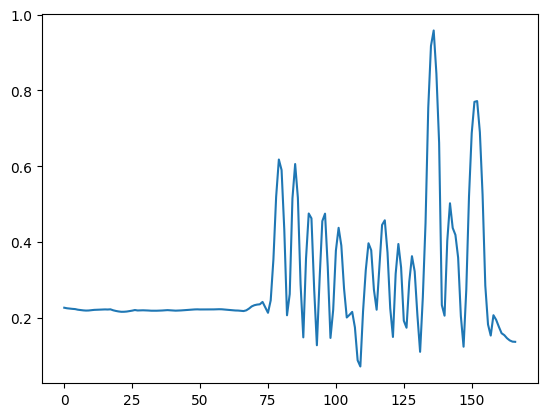

[ 79  85  90  96 101 112 118 123 128 136 142 152]


In [216]:
time = []
month = []
exercises = []
ex_names = []
#count how many exercise of the same type were performed at that month
countexmonth = {
    "tug" : [0,0,0,0,0,0,0,0,0,0,0,0]
}

for i in range(len(data)):

    datai = data[i]
    time.append(datai['Time_samples'])
    monthi = datetime.date.fromtimestamp(ctime[i]).month-1
    month.append(monthi)
    shoulderCenter = datai['Keypoints']['shoulderCenter']
    head = datai['Keypoints']['head']
    shoulderLeft = datai['Keypoints']['shoulderLeft']
    shoulderRight = datai['Keypoints']['shoulderRight']
    elbowLeft = datai['Keypoints']['elbowLeft']
    handLeft = datai['Keypoints']['handLeft']
    elbowRight = datai['Keypoints']['elbowRight']
    handRight = datai['Keypoints']['handRight']
    hipLeft = datai['Keypoints']['hipLeft']
    hipRight = datai['Keypoints']['hipRight']
    ankleLeft = datai['Keypoints']['ankleLeft']
    ankleRight = datai['Keypoints']['ankleRight']
    kneeLeft = datai['Keypoints']['kneeLeft']
    kneeRight = datai['Keypoints']['kneeRight']
    footLeft = datai['Keypoints']['footLeft']
    footRight = datai['Keypoints']['footRight']
    hipCenter = datai['Keypoints']['hipCenter']

    key_pam = {
        "shoulderCenter" : shoulderCenter,
        "head" : head,
        "shoulderLeft" : shoulderLeft,
        "shoulderRight" : shoulderRight,
        "elbowLeft" : elbowLeft,
        "handLeft" : handLeft,
        "elbowRight" : elbowRight,
        "handRight" : handRight,
        "hipLeft" : hipLeft,
        "hipRight" : hipRight,
        "ankleLeft" : ankleLeft,
        "ankleRight" : ankleRight,
        "kneeLeft" : kneeLeft,
        "kneeRight" : kneeRight,
        "footLeft" : footLeft,
        "footRight" : footRight,
        "hipCenter" : hipCenter
    }
    s=Skeleton(key_pam)
    #s.show()

    exname = datai["Exercise"]["name"]
    exname = re.sub(r'[^\w]','',exname)
    ex_names.append(exname)
    result_singleexercise = []
    allmet = datai["Exercise"]["metrics"]
    metrics = allmet.keys()
    for metname in metrics:

        if "step" in metname:
            flt = allmet[metname]["median_filter_window"]
            proj = allmet[metname]["enable_plane_projection"]
            proj = True
            tstanding = time[0][in_stand_idx]
            tforward = time[0][in_wf_idx]
            tturning1 = time[0][fin_wf_idx]
            tbackward = time[0][fin_turn1_idx]
            tturning2 = time[0][fin_wb_idx]
            tsitting = time[0][fin_turn2_idx]
            tend = time[0][fin_sit_idx]
            step_thresh = allmet[metname]["step_thresh"]
            step_thresh = 0.25
            step = Step(flt,proj,tstanding, tforward, tturning1, tbackward, tturning2, tsitting, tend, step_thresh)
            step.compute(s)
            stepmet = [step.step_distance, step.nsteps, step.cadence, step.speed, step.ex_time,
                       step.filtered_step_distance, step.strikes, step.step_width, step.step_length]
            result_singleexercise.append((step,stepmet))


    if exname == "tug":
        ex = Tug(monthi,result_singleexercise)

    countexmonth[exname][monthi] = 1 + countexmonth[exname][monthi]

    exercises.append(ex)   

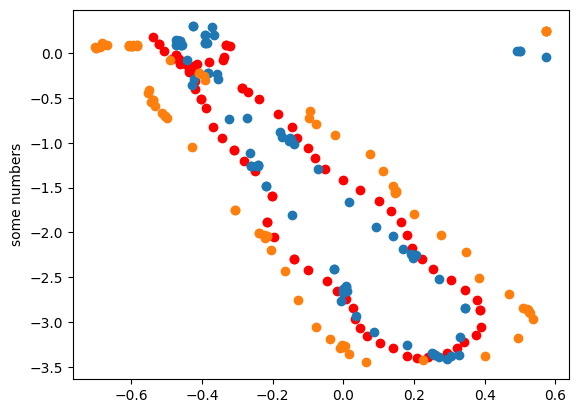

In [191]:
s.keypoints[0].point[:,0]
import matplotlib.pyplot as plt
plt.plot(s.keypoints[0].point[in_stand_idx:in_sit_idx,0], s.keypoints[0].point[in_stand_idx:in_sit_idx,1],'ro')
plt.plot(s.keypoints[11].point[in_stand_idx:in_sit_idx,0], s.keypoints[11].point[in_stand_idx:in_sit_idx,1],'o')
plt.plot(s.keypoints[15].point[in_stand_idx:in_sit_idx,0], s.keypoints[15].point[in_stand_idx:in_sit_idx,1],'o')
plt.ylabel('some numbers')
plt.show()

In [14]:
def compute_kinematics(skeleton, tag):
        sc = skeleton.getKeypoint(tag)

        win=10
        poly_ord=2
        dev_ord=1

        acc_x = scipy.signal.savgol_filter(sc[:,0], win, poly_ord, 2, delta = time[0][1]-time[0][0], axis=0)
        acc_y = scipy.signal.savgol_filter(sc[:,1], win, poly_ord, 2, delta = time[0][1]-time[0][0], axis=0)
        acc_z = scipy.signal.savgol_filter(sc[:,2], win, poly_ord, 2, delta = time[0][1]-time[0][0], axis=0)
        vel_x = scipy.signal.savgol_filter(sc[:,0], win, poly_ord, dev_ord, delta = time[0][1]-time[0][0], axis=0)
        vel_y = scipy.signal.savgol_filter(sc[:,1], win, poly_ord, dev_ord, delta = time[0][1]-time[0][0], axis=0)
        vel_z = scipy.signal.savgol_filter(sc[:,2], win, poly_ord, dev_ord, delta = time[0][1]-time[0][0], axis=0)        

        return vel_x, vel_y, vel_z, acc_x, acc_y, acc_z

vel_shoulCenter_x, vel_shoulCenter_y, vel_shoulCenter_z, acc_shoulCenter_x, acc_shoulCenter_y, acc_shoulCenter_z= compute_kinematics(s, "shoulderCenter")
vel_hipCenter_x, vel_hipCenter_y, vel_hipCenter_z, acc_hipCenter_x, acc_hipCenter_y, acc_hipCenter_z = compute_kinematics(s, "hipCenter")
vel_ankleLeft_x, vel_ankleLeft_y, vel_ankleLeft_z, acc_ankleLeft_x, acc_ankleLeft_y, acc_ankleLeft_z = compute_kinematics(s, "ankleLeft")
vel_ankleRight_x, vel_ankleRight_y, vel_ankleRight_z, acc_ankleRight_x, acc_ankleRight_y, acc_ankleRight_z = compute_kinematics(s, "ankleRight")
vel_shoulRight_x, vel_shoulRight_y, vel_shoulRight_z, acc_shoulRight_x, acc_shoulRight_y, acc_shoulRight_z = compute_kinematics(s, "shoulderRight")
vel_shoulLeft_x, vel_shoulLeft_y, vel_shoulLeft_z, acc_shoulLeft_x, acc_shoulLeft_y, acc_shoulLeft_z = compute_kinematics(s, "shoulderLeft")

In [15]:
dur= 49 #49
nsigma=3

###
init_mean= np.mean(acc_hipCenter_z[0:dur])
init_std= np.std(acc_hipCenter_z[0:dur])
cond1 = np.where(np.abs((acc_hipCenter_z-init_mean)/init_std) > nsigma)[0]

cond2=np.where(np.diff(np.sign(acc_hipCenter_y-acc_shoulCenter_y)))[0]

in_stand_idx= np.intersect1d(cond1,cond2)[0]

###
init_mean= np.mean(acc_ankleRight_y[0:dur])
init_std= np.std(acc_ankleRight_y[0:dur])
in_wf_Right_y_idx = np.where(np.abs((acc_ankleRight_y-init_mean)/init_std) > nsigma)[0]
in_wf_Right_y_idx = np.where(vel_ankleRight_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
init_mean= np.mean(acc_ankleLeft_y[0:dur])
init_std= np.std(acc_ankleLeft_y[0:dur])
in_wf_Left_y_idx = np.where(np.abs((acc_ankleLeft_y-init_mean)/init_std) > nsigma)[0]
in_wf_Left_y_idx = np.where(vel_ankleLeft_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
#in_wf_idx= np.minimum(in_wf_Right_y_idx, in_wf_Left_y_idx)[0]
if in_wf_Right_y_idx[0]<in_wf_Left_y_idx[0]:
    cond1 = in_wf_Right_y_idx
else:
    cond1 = in_wf_Left_y_idx

cond2 = np.array(np.where(vel_hipCenter_y[in_stand_idx:]<0.))[0]+in_stand_idx-2#
in_wf_idx=np.intersect1d(cond1,cond2)[0]

#cond1 = np.array(np.where(acc_shoulRight_x>0))[0]
diff_vel_x=vel_shoulRight_x-vel_shoulLeft_x
diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
cond1= np.array(np.where(diff_acc_x>0))[0]

rfoot_cross3m = np.array(np.where(s.keypoints[15].point[:,1]<-3.))[0]#
lfoot_cross3m = np.array(np.where(s.keypoints[11].point[:,1]<-3.))[0]#
if rfoot_cross3m[0]<lfoot_cross3m[0]:
    foot_cross3m = rfoot_cross3m
else:
    foot_cross3m = lfoot_cross3m

fin_wf_idx=np.intersect1d(cond1,foot_cross3m)[0]

###
diff_shoul = s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0]
cond1= np.array(np.where(abs(diff_shoul[fin_wf_idx:]-abs(diff_shoul[0]))<0.01))[0]

cond2 = np.array(np.where(vel_shoulCenter_y[fin_wf_idx:]>0.))[0]#

fin_turn1_idx=np.intersect1d(cond1,cond2)[0]+fin_wf_idx

###
diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
cond1= np.array(np.where(diff_acc_x[fin_turn1_idx:]<0))[0]

rfoot_cross0m = np.array(np.where(s.keypoints[15].point[fin_turn1_idx:,1]>0.))[0]#
lfoot_cross0m = np.array(np.where(s.keypoints[11].point[fin_turn1_idx:,1]>0.))[0]#
if rfoot_cross0m[0]<lfoot_cross3m[0]:
    foot_cross0m = rfoot_cross0m
else:
    foot_cross0m = lfoot_cross0m

fin_wb_idx=np.intersect1d(cond1,foot_cross0m)[0]+fin_turn1_idx

###
cond1 = np.where(vel_shoulCenter_z[fin_wb_idx:] < 0.)[0]

cond2=np.where(np.diff(np.sign(acc_hipCenter_y[fin_wb_idx:]-acc_shoulCenter_y[fin_wb_idx:])))[0]

fin_turn2_idx= np.intersect1d(cond1,cond2)[0]+fin_wb_idx

###
zero_vel = np.where(np.diff(np.sign(vel_shoulCenter_z[fin_turn2_idx:])))[0]
in_sit_idx= fin_turn2_idx + zero_vel[0]

init_mean= np.mean(acc_shoulCenter_z[:dur])
init_std= np.std(acc_shoulCenter_z[:dur])
outliers_indices1 = np.where(np.abs((acc_shoulCenter_z[fin_turn2_idx:]-init_mean)/init_std) < nsigma)[0]
init_mean= np.mean(s.keypoints[0].point[:dur,2])
init_std= np.std(s.keypoints[0].point[:dur,2])
outliers_indices2 = np.where(np.abs((s.keypoints[0].point[fin_turn2_idx:,2]-init_mean)/init_std) < nsigma)[0]
elem=np.intersect1d(outliers_indices1,outliers_indices2)[0]
fin_sit_idx = fin_turn2_idx + elem


###### L'alzata inizia quando noto un'accelerazione in z del centro delle spalle e, contemporaneamente, una crescita della distanza in y tra il centro delle spalle e il centro delle anche.

In [16]:
dur= 49 #49
nsigma=3


init_mean= np.mean(acc_hipCenter_z[0:dur])
init_std= np.std(acc_hipCenter_z[0:dur])
cond1 = np.where(np.abs((acc_hipCenter_z-init_mean)/init_std) > nsigma)[0]

cond2=np.where(np.diff(np.sign(acc_hipCenter_y-acc_shoulCenter_y)))[0]

in_stand_idx= np.intersect1d(cond1,cond2)[0]

###### La camminata inizia appena uno dei due piedi accelera in y e finisce con l'inizio della rotazione. Quest'ultima inizia quando la distanza in x delle due spalle inizia a descrescere e ho superato la linea dei 3m.

In [17]:
nsigma=3
init_mean= np.mean(acc_ankleRight_y[0:dur])
init_std= np.std(acc_ankleRight_y[0:dur])
in_wf_Right_y_idx = np.where(np.abs((acc_ankleRight_y-init_mean)/init_std) > nsigma)[0]
in_wf_Right_y_idx = np.where(vel_ankleRight_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
init_mean= np.mean(acc_ankleLeft_y[0:dur])
init_std= np.std(acc_ankleLeft_y[0:dur])
in_wf_Left_y_idx = np.where(np.abs((acc_ankleLeft_y-init_mean)/init_std) > nsigma)[0]
in_wf_Left_y_idx = np.where(vel_ankleLeft_y[in_stand_idx:] < -1)[0]+in_stand_idx-2
#in_wf_idx= np.minimum(in_wf_Right_y_idx, in_wf_Left_y_idx)[0]
if in_wf_Right_y_idx[0]<in_wf_Left_y_idx[0]:
    cond1 = in_wf_Right_y_idx
else:
    cond1 = in_wf_Left_y_idx

cond2 = np.array(np.where(vel_hipCenter_y[in_stand_idx:]<0.))[0]+in_stand_idx-2#
in_wf_idx=np.intersect1d(cond1,cond2)[0]

#cond1 = np.array(np.where(acc_shoulRight_x>0))[0]
diff_vel_x=vel_shoulRight_x-vel_shoulLeft_x
diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
cond1= np.array(np.where(diff_acc_x>0))[0]

rfoot_cross3m = np.array(np.where(s.keypoints[15].point[:,1]<-3.))[0]#
lfoot_cross3m = np.array(np.where(s.keypoints[11].point[:,1]<-3.))[0]#
if rfoot_cross3m[0]<lfoot_cross3m[0]:
    foot_cross3m = rfoot_cross3m
else:
    foot_cross3m = lfoot_cross3m

fin_wf_idx=np.intersect1d(cond1,foot_cross3m)[0]

###### La fase di rotazione quando la distanza in x delle due spalle ritorna ai valori iniziali e la velocita' in y del centro spalle e' positiva.

In [18]:
diff_shoul = s.keypoints[5].point[:,0]-s.keypoints[2].point[:,0]
cond1= np.array(np.where(abs(diff_shoul[fin_wf_idx:]-abs(diff_shoul[0]))<0.01))[0]

cond2 = np.array(np.where(vel_shoulCenter_y[fin_wf_idx:]>0.))[0]#

fin_turn1_idx=np.intersect1d(cond1,cond2)[0]+fin_wf_idx

###### La fase di camminata di ritorno termina quando inizia la seconda rotazione.

In [19]:
diff_acc_x=acc_shoulRight_x-acc_shoulLeft_x
cond1= np.array(np.where(diff_acc_x[fin_turn1_idx:]<0))[0]

rfoot_cross0m = np.array(np.where(s.keypoints[15].point[fin_turn1_idx:,1]>0.))[0]#
lfoot_cross0m = np.array(np.where(s.keypoints[11].point[fin_turn1_idx:,1]>0.))[0]#
if rfoot_cross0m[0]<lfoot_cross3m[0]:
    foot_cross0m = rfoot_cross0m
else:
    foot_cross0m = lfoot_cross0m

fin_wb_idx=np.intersect1d(cond1,foot_cross0m)[0]+fin_turn1_idx

###### La seconda rotazione termina quando noto una decelerazione in z del centro delle spalle e, contemporaneamente, una diminuzione della distanza in y tra il centro delle spalle e il centro delle anche.
###### La seconda rotazione termina quando...

In [20]:
nsigma=3
cond1 = np.where(vel_shoulCenter_z[fin_wb_idx:] < 0.)[0]

cond2=np.where(np.diff(np.sign(acc_hipCenter_y[fin_wb_idx:]-acc_shoulCenter_y[fin_wb_idx:])))[0]

fin_turn2_idx= np.intersect1d(cond1,cond2)[0]+fin_wb_idx


In [21]:
nsigma=3
zero_vel = np.where(np.diff(np.sign(vel_shoulCenter_z[fin_turn2_idx:])))[0]
in_sit_idx= fin_turn2_idx + zero_vel[0]

init_mean= np.mean(acc_shoulCenter_z[:dur])
init_std= np.std(acc_shoulCenter_z[:dur])
outliers_indices1 = np.where(np.abs((acc_shoulCenter_z[fin_turn2_idx:]-init_mean)/init_std) < nsigma)[0]
init_mean= np.mean(s.keypoints[0].point[:dur,2])
init_std= np.std(s.keypoints[0].point[:dur,2])
outliers_indices2 = np.where(np.abs((s.keypoints[0].point[fin_turn2_idx:,2]-init_mean)/init_std) < nsigma)[0]
elem=np.intersect1d(outliers_indices1,outliers_indices2)[0]
fin_sit_idx = fin_turn2_idx + elem

/tmp/ipykernel_11060/3293773973.py:8: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_11060/3293773973.py:19: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_11060/3293773973.py:30: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_11060/3293773973.py:41: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_11060/3293773973.py:52: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/tmp/ipykernel_11060/3293773973.py:63: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



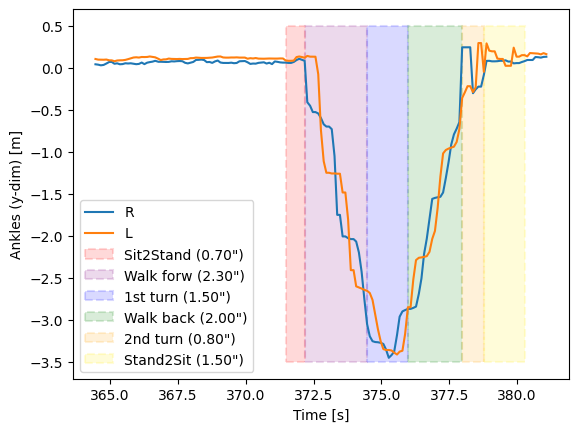

In [22]:
	
import matplotlib.patches as mpatches
plt.plot(time[0][0:-1], s.keypoints[15].point[:,1], label ='R')
plt.plot(time[0][0:-1], s.keypoints[11].point[:,1], label ='L')
plt.xlabel('Time [s]')
plt.ylabel('Ankles (y-dim) [m]')
left, bottom, width, height = (time[0][in_stand_idx], -3.5, time[0][in_wf_idx]-time[0][in_stand_idx], 4)
durata_fase = format(time[0][in_wf_idx]-time[0][in_stand_idx],'.2f')
rect1=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="red",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Sit2Stand ({durata_fase}")',
                       facecolor="red")
plt.gca().add_patch(rect1)
left, bottom, width, height = (time[0][in_wf_idx], -3.5, time[0][fin_wf_idx]-time[0][in_wf_idx], 4)
durata_fase = format(time[0][fin_wf_idx]-time[0][in_wf_idx],'.2f')
rect2=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="purple",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Walk forw ({durata_fase}")',
                       facecolor="purple")
plt.gca().add_patch(rect2)
left, bottom, width, height = (time[0][fin_wf_idx], -3.5, time[0][fin_turn1_idx]-time[0][fin_wf_idx], 4)
durata_fase = format(time[0][fin_turn1_idx]-time[0][fin_wf_idx],'.2f')
rect3=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="blue",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'1st turn ({durata_fase}")',
                       facecolor="blue")
plt.gca().add_patch(rect3)
left, bottom, width, height = (time[0][fin_turn1_idx], -3.5, time[0][fin_wb_idx]-time[0][fin_turn1_idx], 4)
durata_fase = format(time[0][fin_wb_idx]-time[0][fin_turn1_idx],'.2f')
rect4=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="green",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Walk back ({durata_fase}")',
                       facecolor="green")
plt.gca().add_patch(rect4)
left, bottom, width, height = (time[0][fin_wb_idx], -3.5, time[0][fin_turn2_idx]-time[0][fin_wb_idx], 4)
durata_fase= format(time[0][fin_turn2_idx]-time[0][fin_wb_idx],'.2f')
rect5=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="orange",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'2nd turn ({durata_fase}")',
                       facecolor="orange")
plt.gca().add_patch(rect5)
left, bottom, width, height = (time[0][fin_turn2_idx], -3.5, time[0][fin_sit_idx]-time[0][fin_turn2_idx], 4)
durata_fase= format(time[0][fin_sit_idx]-time[0][fin_turn2_idx],'.2f')
rect6=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.15,
                        color="#FFEB00",
                       linewidth=1.5,
                       linestyle='--',
                       label =f'Stand2Sit ({durata_fase}")',
                       facecolor="#FFEB00")
plt.gca().add_patch(rect6)
plt.legend()
#plt.savefig("/home/carmela/dev_iit/assistive-rehab/EsempioFasiTUG.svg", format="svg")

In [27]:
371.46680188179016
372.1683523654938
374.46939849853516
375.9735300540924
377.97315883636475
378.77225136756897
380.27346563339233

8.806663751602173

 
## Report della seduta odierna

 
on: 

 
Di seguito si riporta il grafico:

In [168]:
lastsess_time = time[-1]
lastsess_result = exercises[-1].result
lastsess_res_step = []

%matplotlib inline
%matplotlib inline
for i in range(len(lastsess_result)):
    lastsess_met,lastsess_resi = lastsess_result[i]
    lastsess_metname = lastsess_met.name

    ################
    #     STEP     #
    ################
    if lastsess_metname == "step":
        dist=lastsess_resi[5]
        strikes=lastsess_resi[6]
        trace1 = go.Scatter(
            x=lastsess_time,y=dist,
            mode='lines',
            line=dict(
                color='blue',
                width=3
            ),
            name='Distanza tra i piedi'
        )
        trace2 = go.Scatter(
            x=lastsess_time[strikes],y=dist[strikes],
            mode='markers',
            marker=dict(
                color='red',
                size=10
            ),
            name='Appoggio tallone'
        )
        data = [trace1,trace2]
        layout = dict(
            width=750,
            height=600,
            autosize=False,
            title='Distanza tra i piedi',
            font=dict(family='Courier New, monospace', size=22, color='black'),
            xaxis=dict(
                title='time [s]',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            ),
            yaxis=dict(
                title='dist [m]',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            )
        )
        fig = dict(data=data, layout=layout)
        iplot(fig)

        lastsess_res_step.append(lastsess_resi)
        sla = lastsess_res_step[0][8]
        ns = lastsess_res_step[0][1]
        cad = lastsess_res_step[0][2]
        sp = lastsess_res_step[0][3]
        ex = lastsess_res_step[0][4]
        tablestep = pd.DataFrame([sla, ns, cad, sp, ex])
        tablestep.rename(index={0:"Step Length Avg. [m]",1:"Number of steps",2:"Cadence [steps/s]",
                                3:"Speed [m/s]",4:"Execution time [s]"},
                         columns={0:"Gait analysis"}, inplace=True)
        display(tablestep)



TypeError: only integer scalar arrays can be converted to a scalar index

In [51]:
if exname == 'tug':

    table_tug = pd.DataFrame([['Normale mobilità'],['Buona mobilita'],['Ausili cammino'],['Rischio caduta']],
             index=['< 10 s','< 20 s','< 30 s','>= 30 s'],
             columns=['Tabella TUG'])
    display(table_tug)

    time_score = lastsess_res_step[0][4]
    print("Il test è stato svolto in",round(time_score,2),"s")
    if time_score < 10:
        evaluation = 'Normale mobilità'
        print("La valutazione è [1;30;42m",evaluation)
    elif time_score < 20:
        evaluation = 'Buona mobilità, non necessita ausili'
        print("La valutazione è [1;30;42m",evaluation)
    elif time_score < 30:
        evaluation = 'Necessita ausili cammino'
        print("La valutazione è [1;30;43m",evaluation)
    elif time_score >= 30:
        evaluation = 'Rischio caduta'
        print("La valutazione è [1;30;41m",evaluation)


,Tabella TUG
< 10 s,Normale mobilità
< 20 s,Buona mobilita
< 30 s,Ausili cammino
>= 30 s,Rischio caduta


Il test è stato svolto in 16.81 s
La valutazione è  Buona mobilità, non necessita ausili
